# Object Detection with Region Based Convolutional Neural Network.

You should have seen in our previous posts that Convolutional Neural Network is the state of the art for any computer vision task like

- [Image classification](https://www.learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/)


- [Semantic Segmentation](https://www.learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/)

In this notebook we will look at another computer vision application called object detection 

# Object Localization

In addition to classify an image, we want to know where in the image the object is. So we want to classify the image as cat/dog/..etc and we want to draw a bounding box around the region of the object in the image.

 
 But Object localization is pretty simple, it classifies an image like image classiifcation and draw a bounding box around the classified image. So if more that 1 class is present in the image, it ignores the other class and classifies image as a single class and draw box around it.
 
 Now given an image, the model will return the probability of the content of the image belonging to different known classes and the model will also return 4 floating values of the coordinates of the bounding box.
 


# Object Detection
  
  Object Detection is the next step of Object Localization where the task remains the same(classification and bounding box) but obejct detection input images may have multiple known class objects in a single image and the task is to draw a bounding box around all the objects and classify each object.
  
  The main challenge here is that there might be a varying number of objects in every input image.


- ## Sliding Window Approach
  Sliding window is one of the oldest approach in object detection where the input image is split into multiple crops and each crop of the image is classified and if the crop contains a class, then the crop is decided as the bounding box. But this approach is never used in practice as each input image may have 1000s of such crops and each crop passing through the network for classification may take time.
  
- ## Region Proposal (RCNN)
  Image processing techniques are used to make list of proposed regions in the input image which are then sent through the network for classification. But this is computationally more efficient than sliding window approach as only fewer potential crops which may contain the object is classified by the network.
  
  ![](https://cdn-images-1.medium.com/max/800/1*REPHY47zAyzgbNKC6zlvBQ.png)
  Image Source :  [Ross Girshick et al](https://arxiv.org/pdf/1311.2524.pdf)
  
  RCNN is better than sliding window, but its still computationally expensive as the network has to classify all the region proposals. It takes around 30-40s for inference of a single image.
  
  
- ## Fast Region Proposal (Fast RCNN)
  In fast RCNN, rather than getting region proposals and classifying each region proposals, the input image is sent into the CNN network which gives a feature map of the image. Again some region proposals are used but now we get the region proposals from the feature map of the image and these feature maps are classified. This reduces the computation as some of the CNN layers are common for the whole image. 
  
  ![](https://cdn-images-1.medium.com/max/800/1*0pMP3aY8blSpva5tvWbnKA.png)
  Image Source : [Ross Gishich](https://arxiv.org/pdf/1504.08083.pdf)
  

- ## Faster R-CNN
  The idea of Faster R-CNN is to use CNNs to propose potential region of interest and the network is called Region Proposal Network. After getting the region proposals , its just like Fast RCNN, we use every regions for classification.
![](https://www.researchgate.net/profile/Giang_Son_Tran/publication/324549019/figure/fig1/AS:649929152266241@1531966593689/Faster-R-CNN-Architecture-9.png)

# Object Detection, Instance Segmentation and Person Keypoint Detection in PyTorch

It is fine if you don't understand every detail of the models discussed above. If you want to learn more about all of these models and many more application and concepts of Deep Learning and Computer Vision indetail,  check out the official [Deep Learning and Computer Vision courses](https://opencv.org/courses/) by OpenCV.org. 

Now we will use pre trained models in PyTorch for
  - Object Detection
  - Instance Segmentation 
  - Person Keypoint Detection
  
  
  All the pretrained models in pytorch can be found in [torchvision.models](https://pytorch.org/docs/stable/torchvision/models.html)
  

# Object Detection with PyTorch

The pretrained Faster-RCNN ResNet-50 model we are going to use expects the input image tensor to be in the form ```[n, c, h, w]``` 
where 
- n is the number of images
- c is the number of channels , for RGB images its 3
- h is the height of the image
- w is the widht of the image

The model will return
- Bounding boxes [x0, y0, x1, y1]  all all predicted classes of shape (N,4) where N is the number of classes predicted by the model to be present in the image.
- Labels of all predicted classes.
- Scores of each predicted label.



In [4]:
# import necessary libraries
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import torch
import numpy as np
import cv2
import os

# get the pretrained model from torchvision.models
# Note: pretrained=True will get the pretrained weights for the model.
# model.eval() to use the model for inference
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# import pickle

# # Load from file
# pkl_filename = "fasterrcnn_model.pkl"
# with open(pkl_filename, 'rb') as file:
#     model = pickle.load(file)
model.eval()

# Class labels from official PyTorch documentation for the pretrained model
# Note that there are some N/A's 
# for complete list check https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
# we will use the same list for this notebook
COCO_INSTANCE_CATEGORY_NAMES = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
                                'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
                                'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
                                'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
                                'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
                                'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
                                'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
                                'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
                                'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
                                'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
                                'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
                                'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

Let's create a few helper functions to run inference on the image and display the output bounding boxes on the image.

In [10]:
def get_prediction(img_path, threshold):
  """
  get_prediction
    parameters:
      - img_path - path of the input image
      - threshold - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.
    
  """
  img = Image.open(img_path).convert('RGB')
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class, 
  


def object_detection_api(img_path, threshold=0.5, rect_th=1, text_size=2, text_th=3):
  """
  object_detection_api
    parameters:
      - img_path - path of the input image
      - threshold - threshold value for prediction score
      - rect_th - thickness of bounding box
      - text_size - size of the class label text
      - text_th - thichness of the text
    method:
      - prediction is obtained from get_prediction method
      - for each prediction, bounding box is drawn and text is written 
        with opencv
      - the final image is displayed
  """
  boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(boxes)):
    cv2.rectangle(img, (int(boxes[i][0][0]),int(boxes[i][0][1])), (int(boxes[i][1][0]), int(boxes[i][1][0])), color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], (int(boxes[i][0][0]),int(boxes[i][0][1])), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  print(f"The number of identified objects is {len(boxes)}")
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

The number of identified objects is 5


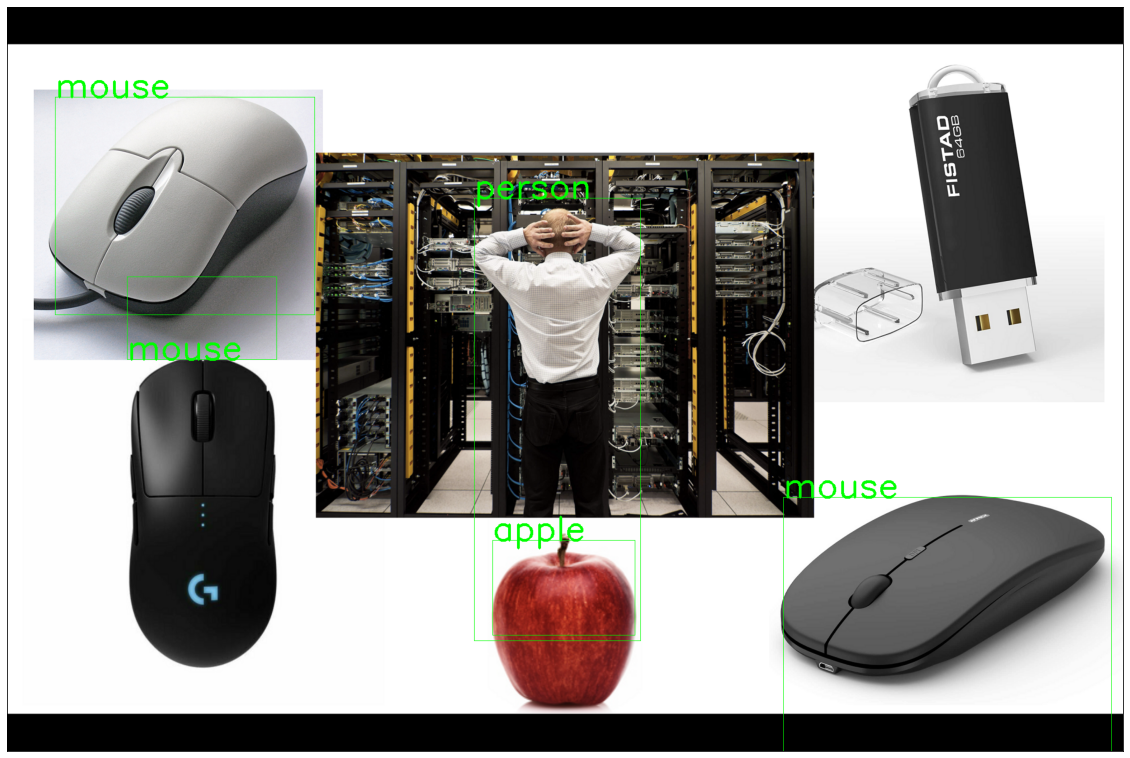

In [11]:
object_detection_api('test.png', threshold=0.8)